In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import h5py
from tqdm import tqdm
from glob import glob
from scipy.interpolate import CubicSpline
from copy import deepcopy
import datetime as dt
from pathlib import Path

In [2]:
parameter_dict = {
        'acc_long':     {'bstar': 198,      'rstar': 1,     'b': 198,   'r': 0.05   },
        'acc_trans':    {'bstar': 32768,    'rstar': 1,     'b': 32768, 'r': 0.04   },
        'acc_yaw':      {'bstar': 2047,     'rstar': 1,     'b': 2047,  'r': 0.1    },
        'brk_trq_elec': {'bstar': 4096,     'rstar': -1,    'b': 4098,  'r': -1     },
        'whl_trq_est':  {'bstar': 12800,    'rstar': 0.5,   'b': 12700, 'r': 1      },
        'trac_cons':    {'bstar': 80,       'rstar': 1,     'b': 79,    'r': 1      },
        'trip_cons':    {'bstar': 0,        'rstar': 0.1,   'b': 0,     'r': 1      }
    }

def convertdata(data, parameter):
    bstar = parameter['bstar']
    rstar = parameter['rstar']
    b = parameter['b']
    r = parameter['r']
    # We only convert data in the second column at idx 1 (wrt. 0-indexing), as the first column is time
    col0 = data[:,0]
    col1 = ((data[:,1]-bstar*rstar)-b)*r
    data = np.column_stack((col0, col1))
    return data


def unpack_hdf5(hdf5_file, convert: bool = False):
    with h5py.File(hdf5_file, 'r') as f:
        data = unpack_hdf5_(f, convert)
    return data


def unpack_hdf5_(group, convert: bool = False):
    data = {}
    for key in group.keys():
        if isinstance(group[key], h5py.Group):
            data[key] = unpack_hdf5_(group[key])
        else:
            if convert and key in parameter_dict:
                data[key] = convertdata(group[key][()], parameter_dict[key])
            else:
                d = group[key][()]
                if isinstance(d, bytes):
                    data[key] = d.decode('utf-8')
                else:
                    data[key] = group[key][()]
    return data

In [3]:
autopi_hh = unpack_hdf5('../data/raw/AutoPi_CAN/platoon_CPH1_HH.hdf5')
autopi_vh = unpack_hdf5('../data/raw/AutoPi_CAN/platoon_CPH1_VH.hdf5')

In [4]:
trip_folders = glob('../data/raw/gopro_data/car*/*')
trip_folders = sorted(trip_folders)

gopro_data = {}

pbar = tqdm(trip_folders, total=len(trip_folders))
for trip_folder in pbar:
    car, trip_id = trip_folder.split('\\')[-2:]
    if car not in gopro_data:
        gopro_data[car] = {}
    
    gopro_data[car][trip_id] = {}
    for measurement in ['gps5', 'accl', 'gyro']:
        gopro_data[car][trip_id][measurement] = pd.read_csv(f'{trip_folder}/{trip_id}_HERO8 Black-{measurement.upper()}.csv')
        gopro_data[car][trip_id][measurement]['date'] = pd.to_datetime(gopro_data[car][trip_id][measurement]['date']).map(dt.datetime.timestamp)
        pbar.set_description(f'Loading {car} {trip_id}')

  0%|          | 0/15 [00:00<?, ?it/s]

Loading car3 GH060053: 100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


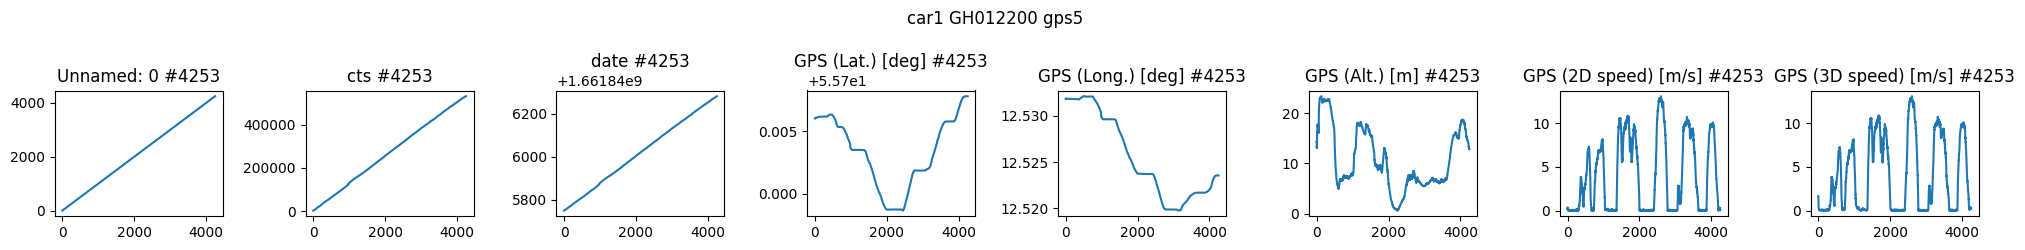

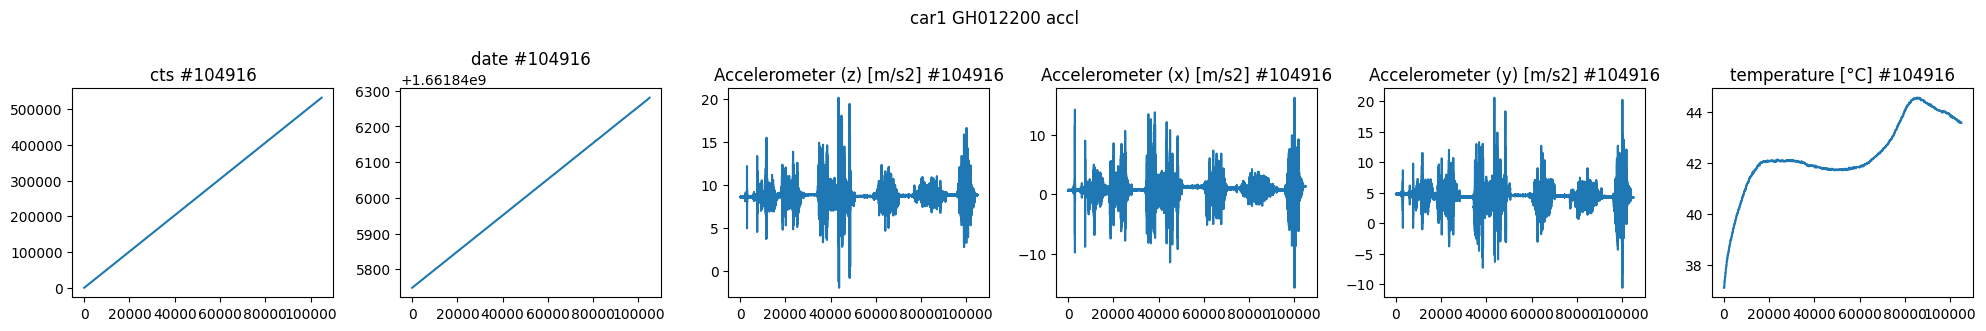

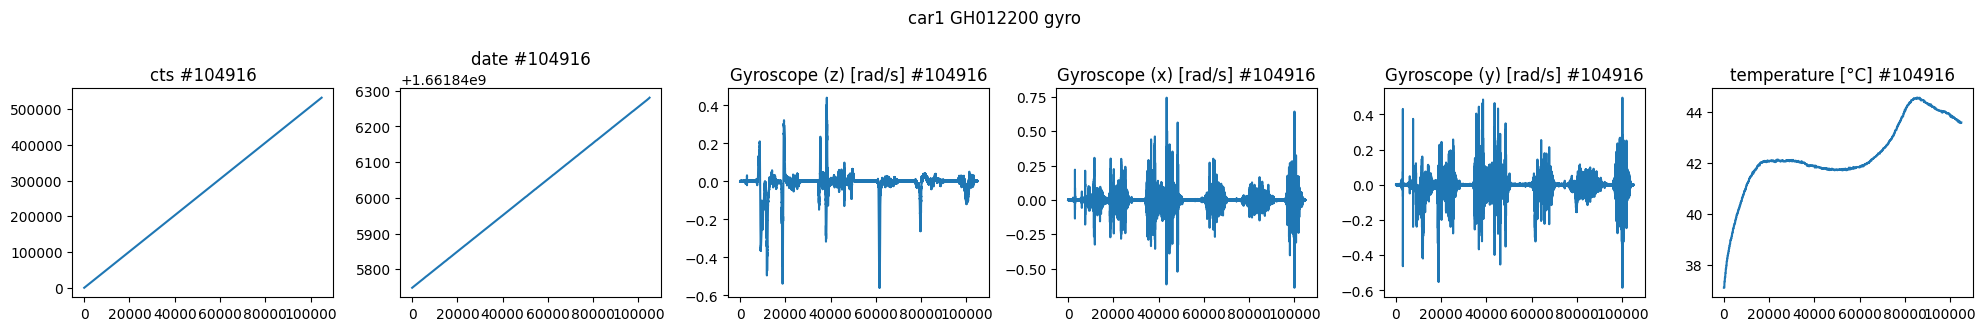

In [5]:
car = "car1"
trip_id = "GH012200"

for key, measurement in gopro_data[car][trip_id].items():
    # Plot one figure for each attribute in data
    cols = measurement.columns
    fig, ax = plt.subplots(1, len(cols), figsize=(20, 20/len(cols)))

    for i, col in enumerate(cols):
        ax[i].plot(np.array(measurement[col]))
        ax[i].set_title(f"{col} #{len(measurement[col])}")
    fig.suptitle(f"{car} {trip_id} {key}")
    plt.tight_layout()
    plt.show()


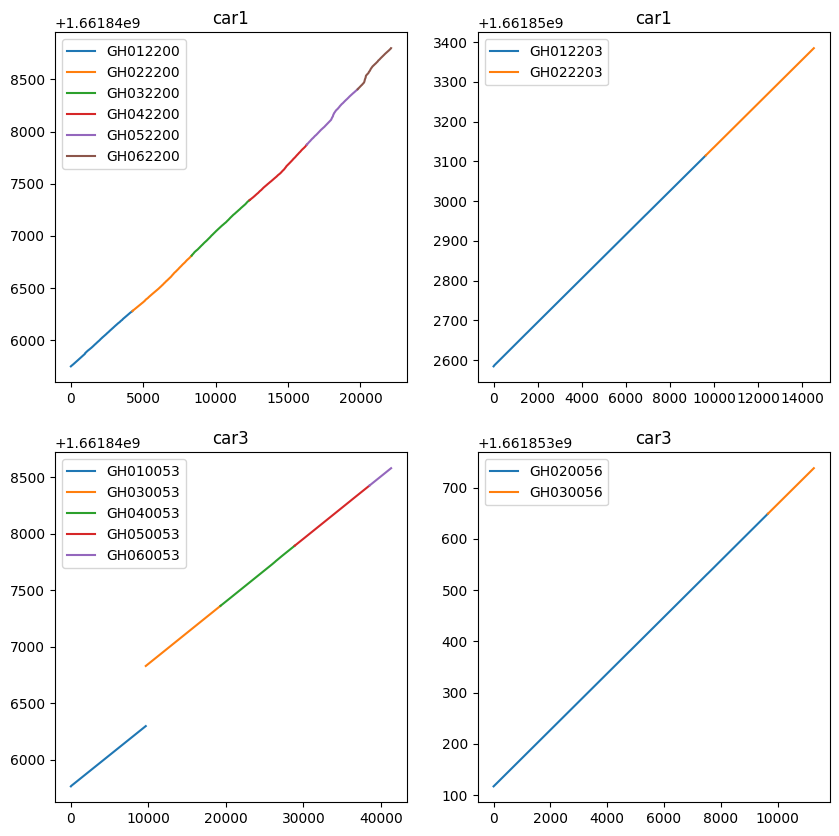

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
car = "car1"
endings = {'car1': ['0', '3'], 'car3': ['3', '6']}
for r, car in enumerate(gopro_data.keys()):
    for c, ending in enumerate(endings[car]):
        i = 0
        for trip_id, trip in gopro_data[car].items():
            if trip_id[-1] == ending:
                date = trip['gps5']['date']
                n = len(date)
                axes[r, c].plot(range(i, i+n), date, label=trip_id)
                i += n
        axes[r, c].set_title(car)
        axes[r, c].legend()
plt.show()

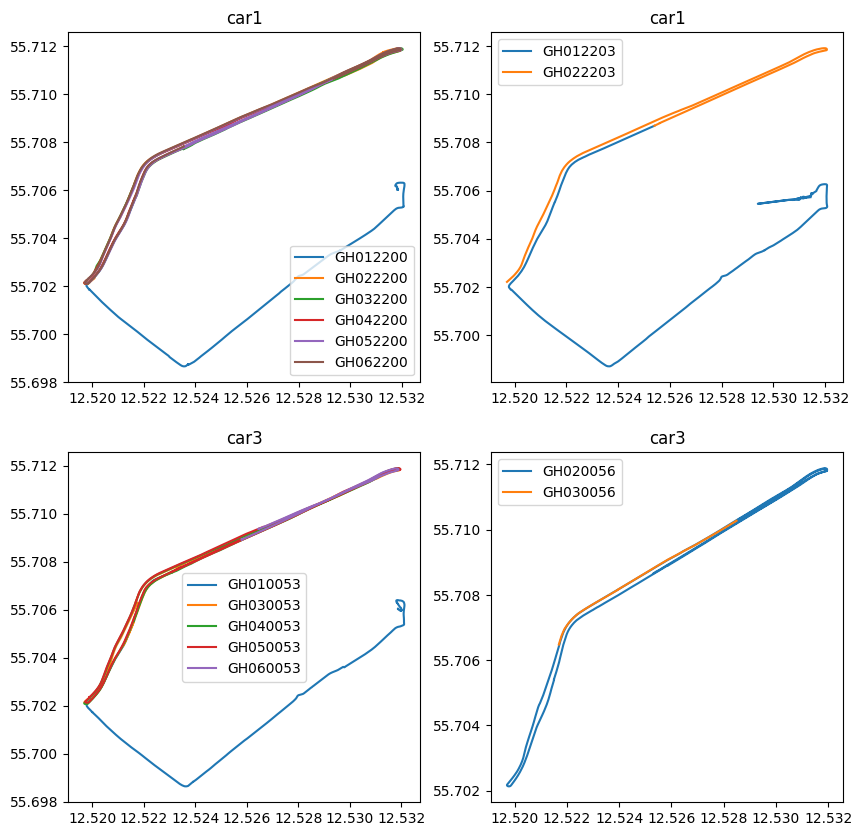

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
car = "car1"
endings = {'car1': ['0', '3'], 'car3': ['3', '6']}
for r, car in enumerate(gopro_data.keys()):
    for c, ending in enumerate(endings[car]):
        for trip_id, trip in gopro_data[car].items():
            if trip_id[-1] == ending:
                long = trip['gps5']["GPS (Long.) [deg]"]
                lat = trip['gps5']["GPS (Lat.) [deg]"]
                axes[r, c].plot(long, lat, label=trip_id)
        axes[r, c].set_title(car)
        axes[r, c].legend()
plt.show()

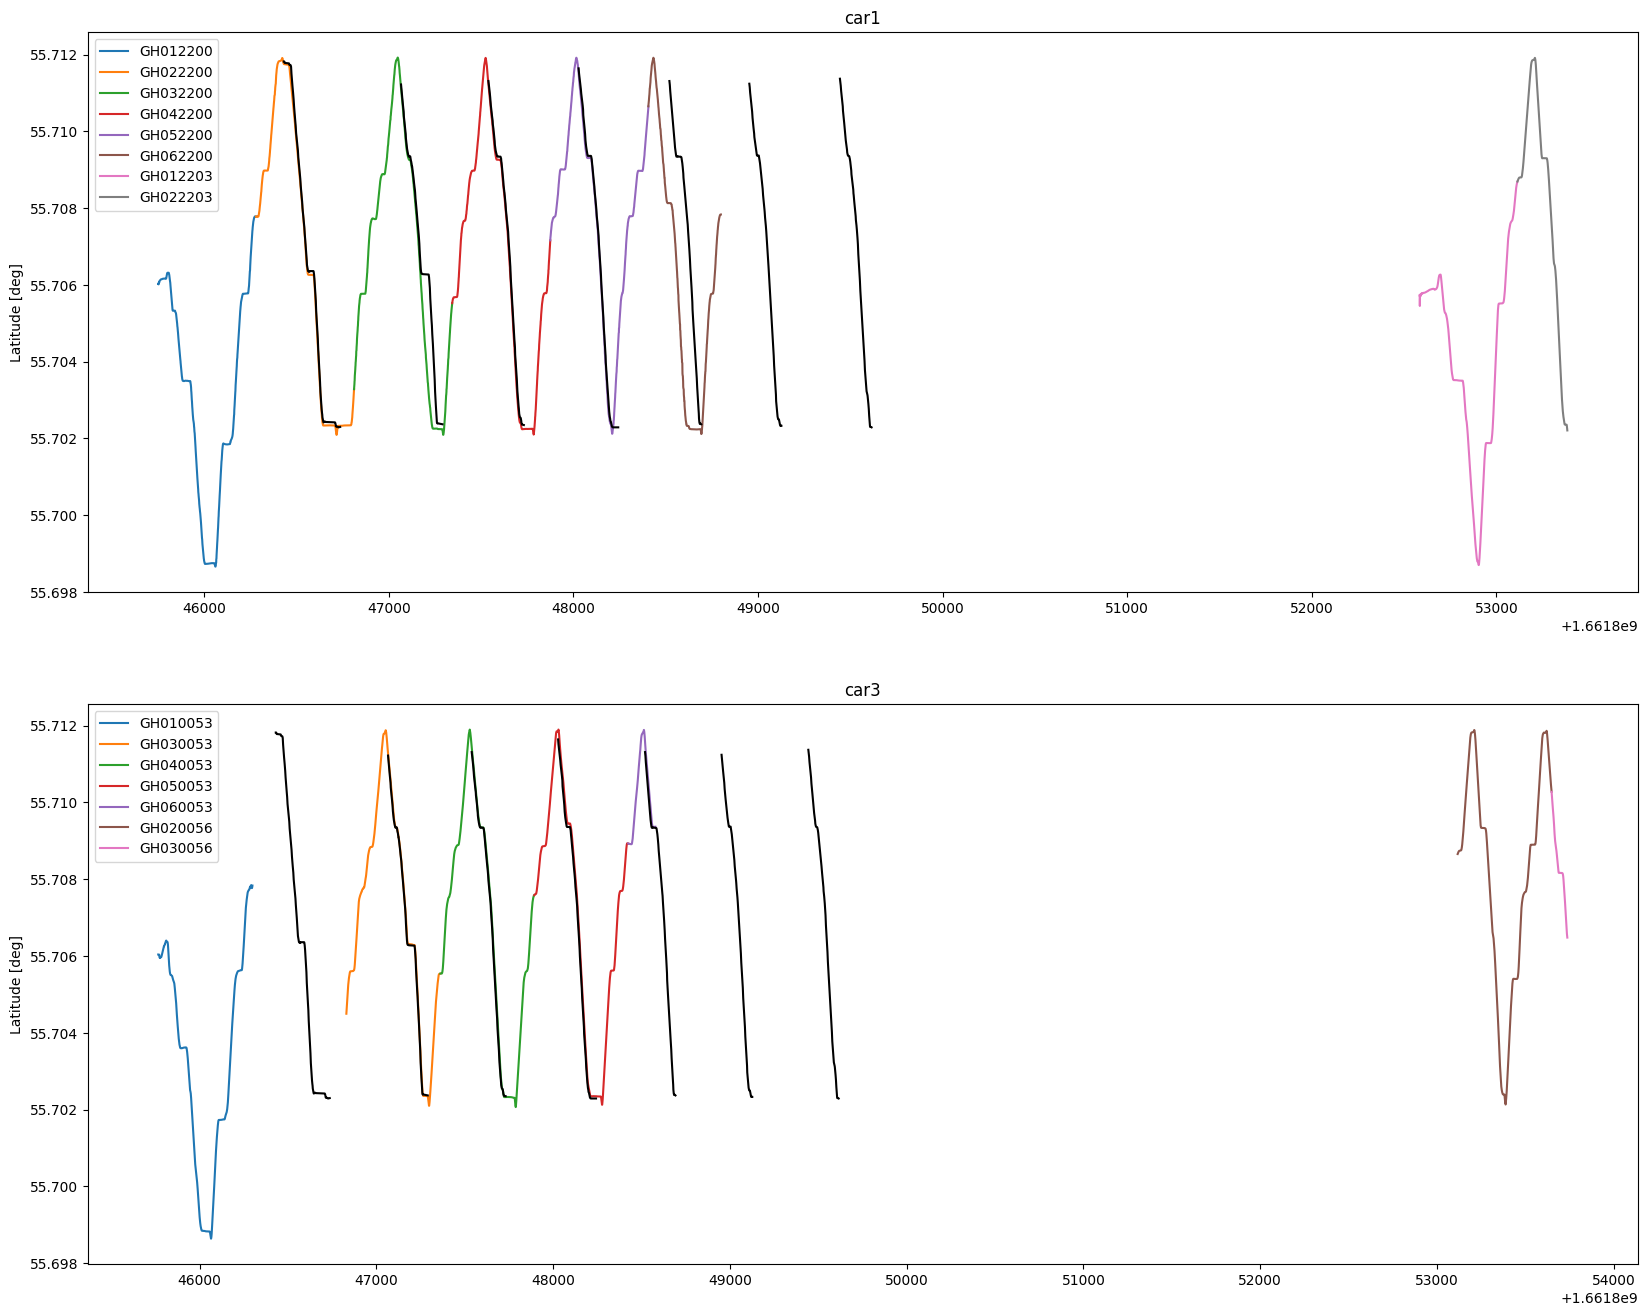

In [29]:
fig, axes = plt.subplots(2,1, figsize=(20, 16))
car = "car1"
endings = {'car1': ['0', '3'], 'car3': ['3', '6']}
for r, car in enumerate(gopro_data.keys()):
    ax = axes[r]
    for c, ending in enumerate(endings[car]):
        for trip_id, trip in gopro_data[car].items():
            if trip_id[-1] == ending:
                date = trip['gps5']['date']
                lat = trip['gps5']['GPS (Lat.) [deg]']
                ax.plot(date, lat, label=trip_id)
    ax.set_ylabel("Latitude [deg]")
    ax.set_title(car)
    ax.legend()

# for r, car in autopi_hh.items():
#     for c, trip in car.items():
c1 = "16010"
for p in autopi_hh["GM"][c1].keys():
    pass_ = autopi_hh["GM"][c1][p]
    date = pass_['gps'][:, 0]
    lat = pass_['gps'][:, 1]
    axes[0].plot(date, lat, c='k', label=f"{c1} {p}")

c2 = "16010"
for p in autopi_hh["GM"][c2].keys():
    pass_ = autopi_hh["GM"][c2][p]
    date = pass_['gps'][:, 0]
    lat = pass_['gps'][:, 1]
    axes[1].plot(date, lat, c='k', label=f"{c2} {p}")
plt.show()

MATCHINGS:


In [12]:
car1_am_trip = "16011"
car1_am_gopro = ["GH012200", "GH022200", "GH032200","GH042200","GH052200","GH062200"]

car3_am_trip = "16009"
car3_am_gopro = ["GH010053","GH030053", "GH040053","GH050053","GH060053"]

car3_pm_trip = "16006"
car3_pm_gopro = ["GH020056", "GH040053"]

# create interconnected gopro data to match each trip


# EARLY / LATE

# 16006 / 16009
# 16008 / 16010
# ????? / 16011

In [13]:
from pathlib import Path

def csv_files_together(car_trip, go_pro_names, car_number):
    # Load all the gopro data 
    
    for measurement in ['accl', 'gps5', 'gyro']:
        gopro_data = None
        for trip_id in go_pro_names:
            trip_folder = f"../data/raw/gopro_data/{car_number}/{trip_id}"
            new_data = pd.read_csv(f'{trip_folder}/{trip_id}_HERO8 Black-{measurement.upper()}.csv')
            new_data['date'] = pd.to_datetime(new_data['date']).map(dt.datetime.timestamp)
            if "unknow" in new_data.columns:
                new_data.drop("unknown")
        
            if gopro_data is not None:
                gopro_data = pd.concat([gopro_data, new_data])
            else:
                gopro_data = new_data
            
        # save gopro_data[measurement
        new_folder = f"../data/raw/gopro_data/{car_trip}"
        Path(new_folder).mkdir(parents=True, exist_ok=True)
        
        gopro_data.to_csv(f"{new_folder}/{measurement}.csv", index=False)
        

In [14]:
csv_files_together(car1_am_trip, car1_am_gopro, "car1")

In [15]:
# Load the gopro data 
gopro_data = {}
for trip_id in ["16006", "16009", "16011"]:
    gopro_data[trip_id] = {}
    for measurement in ['gps5', 'accl', 'gyro']:
        gopro_data[trip_id][measurement] = pd.read_csv(f'../data/raw/gopro_data/{trip_id}/{measurement}.csv')
    
    
# # Load the AutoPi segmented data 
current_segment = unpack_hdf5('../data/interim/gm/segment_070.hdf5')
current_segment["trip_name"]

'16009'

In [16]:
def find_best_start_and_end_indeces_by_time(current_segment, gopro_time):
    # Find the start and end indeces of the section data based on time
    
    current_segment_start_time = current_segment["measurements"]["gps"][0][0]
    current_segment_end_time = current_segment["measurements"]["gps"][-1][0]
    segment_time = [current_segment_start_time, current_segment_end_time]
    
    diff_start = (gopro_time - segment_time[0]).abs()
    start_index = diff_start.idxmin()
    start_diff = diff_start.min()
    
    diff_end = (gopro_time - segment_time[1]).abs()
    end_index = diff_end.idxmin()
    end_diff = diff_end.min()

    return start_index, end_index, start_diff, end_diff

In [19]:
segment_files = glob('../data/interim/gm/*.hdf5')
for segment_file in segment_files:
    current_segment = unpack_hdf5(segment_file)
    if current_segment["trip_name"] not in ["16006", "16009", "16011"]:
        continue
    
    for measurement in ['gps5', 'accl', 'gyro']:
        start_index, end_index, start_diff, end_diff = find_best_start_and_end_indeces_by_time(current_segment, gopro_data[current_segment["trip_name"]][measurement]["date"])

        if max(start_diff, end_diff) > 1:
            continue
        
        gopro_segment = gopro_data[current_segment["trip_name"]][measurement][start_index:end_index]
        Path(f"../data/interim/gopro/{measurement}/").mkdir(parents=True, exist_ok=True)
        gopro_segment.to_csv(f'../data/interim/gopro/{measurement}/segment_{segment_file[-8:-5]}.csv', sep=';', index=False)
        

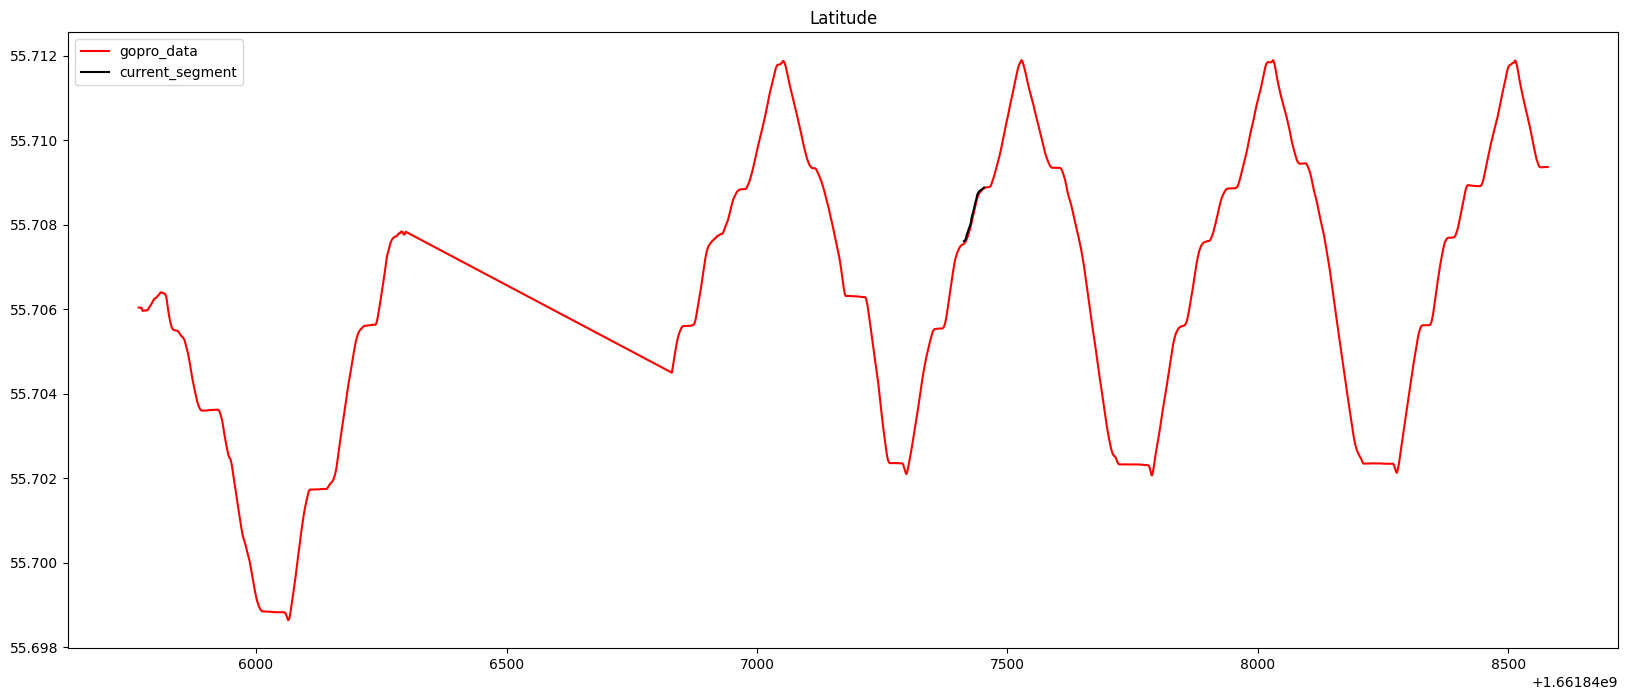

In [245]:
fig, axes = plt.subplots(1,1, figsize=(20, 8))
current_segment_lat = current_segment["measurements"]["gps"][:, 1]
current_segment_time = current_segment["measurements"]["gps"][:, 0]

# plot the two lines
axes.plot(gopro_time, gopro_lat, c='r', label="gopro_data")
axes.plot(current_segment_time, current_segment_lat, c='k', label="current_segment")
axes.set_title("Latitude")
axes.legend()
plt.show()